In [1]:
import EoN
import numpy as np
import networkx as nx
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

import pymc3 as pm
import random
import scipy.sparse as sps

from tqdm.autonotebook import tqdm
import time

plt.style.use('seaborn-white')
sns.set_style("ticks")
sns.set_context("talk")
%matplotlib inline

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
/Users/agarbuno/anaconda2/envs/risknet/lib/python3.6/site-packages/ipykernel_launcher.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if sys.path[0] == '':


In [2]:
import sys
sys.path.append('/Users/agarbuno/github-repos/collaborations/covid/risk-networks/risknet')

In [3]:
%load_ext autoreload
%autoreload 2
import epimodels
import ensemble

In [4]:
N = 10000
# N = 2253
# G = nx.fast_gnp_random_graph(N, 5./(N-1))
G = nx.powerlaw_cluster_graph(N, 20, 5./(N-1))
# G = nx.barabasi_albert_graph(N, 5) 

In [5]:
random.seed(1)

In [6]:
edge_list = np.loadtxt('../data/networks/High-School_data_2013.csv', usecols = [1,2], dtype = int) 
# edge_list = np.loadtxt('networks/thiers_2012.csv', usecols = [1,2], dtype = int) 

G = nx.Graph([tuple(k) for k in edge_list])
G = nx.relabel_nodes(G,dict(zip(list(G.nodes()), range(len(list(G.nodes()))))))

N = len(list(G.nodes))
# N = np.array(list(G.nodes())).max() + 1

In [7]:
print('Size of sparse csr_matrix: '+ '%3.2f' % (round(nx.to_scipy_sparse_matrix(G).data.size/(1024**2),3)) + ' MB')

Size of sparse csr_matrix: 0.01 MB


(array([10., 17., 62., 73., 99., 36., 19.,  6.,  3.,  2.]),
 array([ 2. , 10.5, 19. , 27.5, 36. , 44.5, 53. , 61.5, 70. , 78.5, 87. ]),
 <a list of 10 Patch objects>)

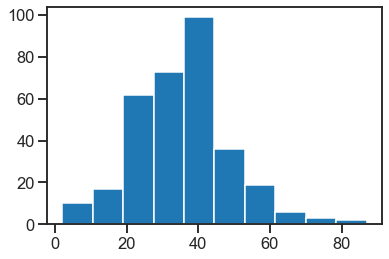

In [8]:
plt.hist(np.array(list(dict(G.degree).values())))

In [9]:
epistatic = epimodels.static(G, N)

In [10]:
epistatic.init(beta = 0.06)

In [11]:
infected = np.random.choice(N, size = 50, replace = False)
epistatic.init_infected(infected)

In [12]:
nsims = 10
sims  = []

return_statuses = ('S', 'E', 'I', 'H', 'R', 'D')

for kk in tqdm(np.arange(nsims), desc = 'Simulations'):
    sim = epistatic.simulate(return_statuses)
    sims.append(sim)

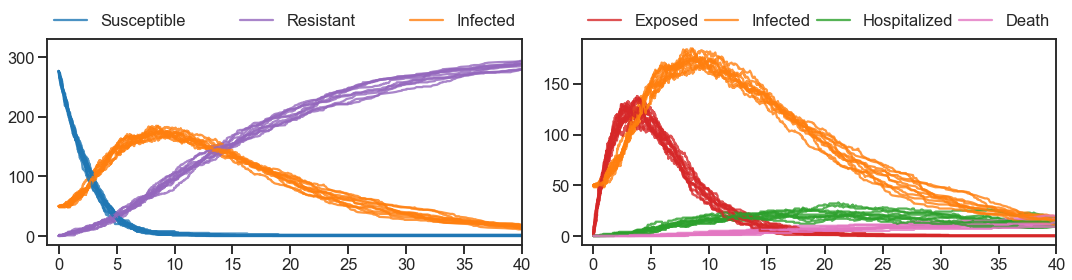

In [13]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
alpha = .8

for sim in tqdm(sims, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);

for ax in axes:
    ax.set_xlim(-1, 40)

plt.tight_layout()

In [14]:
E, I, H, R, D = np.zeros([5, N])
S = np.ones(N,)
I[infected] = 1.
S[infected] = 0.

In [15]:
y0 = np.hstack((S, E, I, H, R, D))
T = 40
t = np.linspace(0,T,201)

In [16]:
start_time = time.time()

epistatic.set_solver(T = T, dt = 30.)
ke = epistatic.solve(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

Runtime: 00:00:00


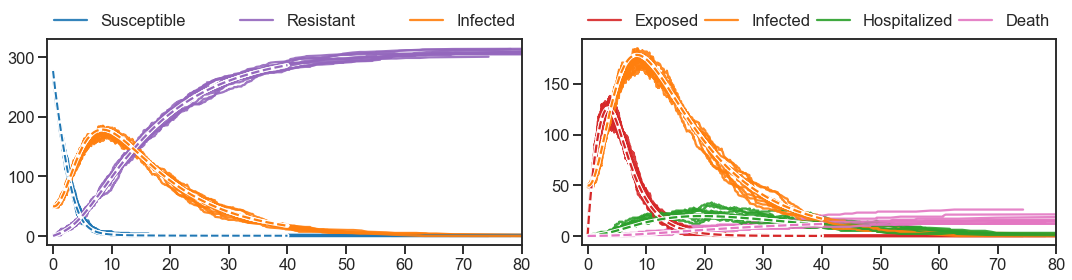

In [17]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .9

for sim in tqdm(sims, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)
    
    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'C6', linestyle = '--')
    
axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for ax in axes:
    ax.set_xlim(-1, 80)

plt.tight_layout()

In [18]:
tqdm.write('Number of probabilities exceeding upper bound: %s'%(ke.y.reshape(6,-1,201).max(axis = 0) > 1.0).sum())

Number of probabilities exceeding upper bound: 0


# Ensemble simulation - covariance based - homogeneous network

In [19]:
M = 100
ens = ensemble.epiens(M, G, N)
np.random.seed(1)
ens.init()

In [20]:
E, I, H, R, D = np.zeros([5, N])
S = np.ones(N,)
I[infected] = 1.
S[infected] = 0.

In [21]:
y0 = np.hstack((S, E, I, H, R, D))
y0 = np.tile(y0, ens.M).reshape(ens.M, -1)
T = 40
t = np.linspace(0,T,201)
ens.set_solver(T = T, dt = 30.)

### **Case 1.** This solves $M$ equations with individual-based closures using ``RK45``

In [22]:
start_time = time.time()

ke = ens.ens_solve(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:17


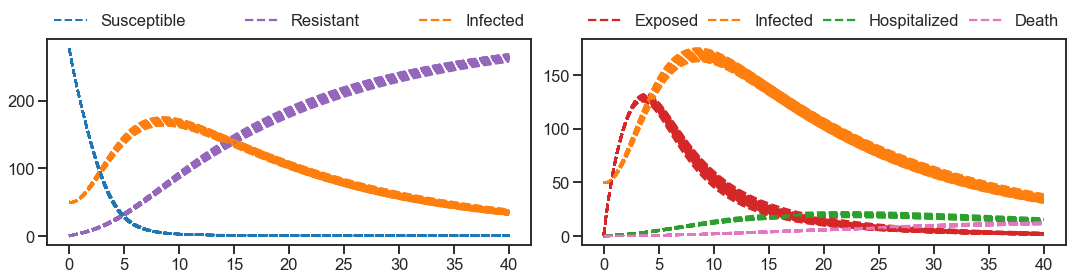

In [23]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .9

for mm in tqdm(range(M), desc = 'Simulations'):
    times, states = sim.summary()
    
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, ke[mm].y.reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'C6', linestyle = '--')

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
# for ax in axes:
#     ax.set_xlim(-1, 80)

plt.tight_layout()

### **Case 2.** This solves the whole system with simple Euler steps, again with the individual-based closure. 

In [24]:
ens.set_solver(T = T, dt = np.diff(t).min())

In [25]:
np.random.seed(1)

start_time = time.time()

ke_euler = ens.ens_solve_euler(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:16


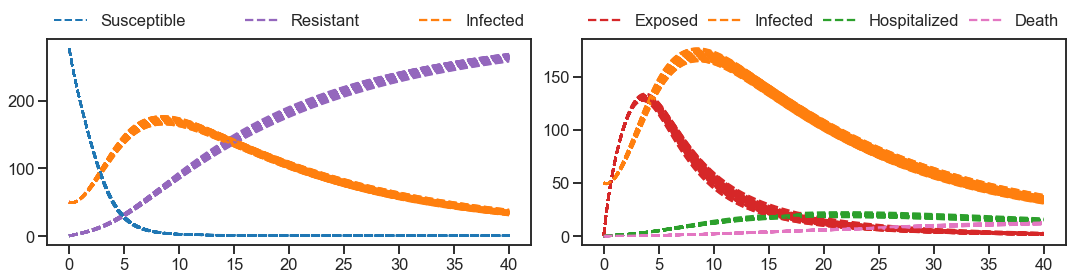

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .9

for mm in tqdm(range(M), desc = 'Simulations'):
    times, states = sim.summary()
    
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'C6', linestyle = '--')

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
# for ax in axes:
#     ax.set_xlim(-1, 80)

plt.tight_layout()

### **Case 3.** This solves the whole system with simple Euler steps, now with the pair-based covariance closure. 

In [27]:
np.random.seed(1)

start_time = time.time()

ke_euler = ens.ens_solve_euler(y0, t, closure = 'covariance')

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


Runtime: 00:00:20


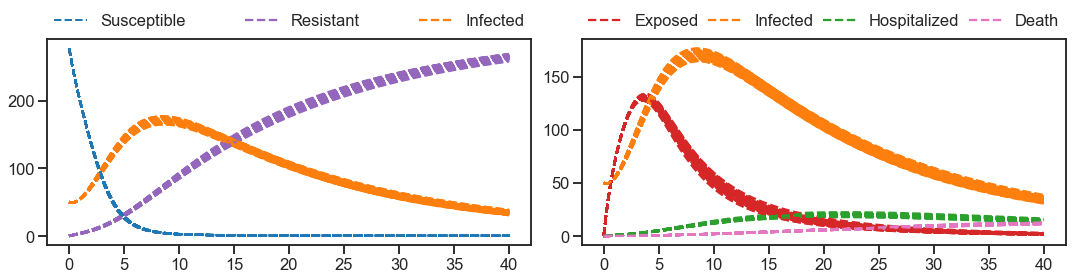

In [28]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .9

for mm in tqdm(range(M), desc = 'Simulations'):
    times, states = sim.summary()
    
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'C6', linestyle = '--')

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
# for ax in axes:
#     ax.set_xlim(-1, 80)

plt.tight_layout()

# ``Warning:`` Correlation-based closure not working

In [ ]:
# np.random.seed(1)

# start_time = time.time()

# ke_euler = ens.ens_solve_euler(y0, t, closure = 'correlation')

# elapsed_time = time.time() - start_time
# tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
# fig, axes = plt.subplots(1, 2, figsize = (15, 4))

# alpha = .9

# for mm in tqdm(range(M), desc = 'Simulations'):
#     times, states = sim.summary()
    
#     axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
#     axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-2], color = 'C4', linestyle = '--')
#     axes[0].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
    
#     axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[1], color = 'C3', linestyle = '--')
#     axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[2], color = 'C1', linestyle = '--')
#     axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-3], color = 'C2', linestyle = '--')
#     axes[1].plot(t, ke_euler[mm].reshape(6, -1, len(t)).sum(axis = 1)[-1], color = 'C6', linestyle = '--')

# axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
#                bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#                ncol=3, mode="expand", borderaxespad=0.);
# axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
#               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
#               ncol=4, mode="expand", borderaxespad=0.);
    
# # for ax in axes:
# #     ax.set_xlim(-1, 80)

# plt.tight_layout()

## ``Debugging:`` checking probabilities

In [ ]:
states = ['Susceptible', 'Exposed', 'Infected', 'Hospitalized', 'Resistant', 'Dead']
colors = ['C0', 'C3', 'C1', 'C2', 'C4', 'C6']

In [ ]:
fig, axes = plt.subplots(3, 2, figsize = (15, 8), sharex = True, sharey = False)

alpha = .3

# for mm in tqdm(range(6), desc = 'Simulations'):
for state, ax in tqdm(enumerate(axes.flatten()), total = 6):
    ax.plot(ke[0].t, ke[0].y.reshape(6,-1,len(t))[state].T, alpha = alpha, color = colors[state]);
    ax.set_title(states[state])

plt.tight_layout()

# Heterogeneous individuals - still not tested!

In [ ]:
sigma     = pm.InverseGamma.dist(alpha = 2, beta = 1./3)

m = 1.8
s = 0.9
invgamma  = pm.Lognormal.dist(mu = np.log(m/np.sqrt(1. + (s/m)**2)), sigma = 2*np.log(1. + (s/m)**2))
s = 1.2
invgammap = pm.Lognormal.dist(mu = np.log(m/np.sqrt(1. + (s/m)**2)), sigma = 2*np.log(1. + (s/m)**2))

h         = pm.Beta.dist(mu = 0.15, sigma = .15)
d         = pm.Beta.dist(mu = 0.14, sigma = .15)
dp        = pm.Beta.dist(mu = 0.42, sigma = .15)

In [ ]:
domain = np.linspace(0.01, 5, 100)

m = 1.8 
s = 0.9
invgamma = pm.Lognormal.dist(mu = np.log(m/np.sqrt(1. + (s/m)**2)), sigma = 2*np.log(1. + (s/m)**2))
plt.plot(domain, [np.exp(invgamma.logp(x).eval()) for x in domain], color = 'C0', label = 'Small variance')

m = 1.8 
s = 1.2
invgamma = pm.Lognormal.dist(mu = np.log(m/np.sqrt(1. + (s/m)**2)), sigma = 2*np.log(1. + (s/m)**2))
plt.plot(domain, [np.exp(invgamma.logp(x).eval()) for x in domain], color = 'C1', label = 'Large Variance')

In [ ]:
domain = np.linspace(0.01, 1, 100)

beta = pm.Beta.dist(mu = 0.15, sigma = .15)
plt.plot(domain, [np.exp(beta.logp(x).eval()) for x in domain], color = 'C1', label = 'Large Variance')

np.round(np.percentile(beta.random(size = 10000), q = [10, 50, 80]), 3)

In [ ]:
np.random.seed(1)

sigma_samps     = sigma.random(size = N)
gamma_samps     = 1./invgamma.random(size = N)
gammap_samps    = 1./(invgammap.random(size = N) + 5.5)
h_samps         = h.random(size = N)
d_samps         = d.random(size = N)
dp_samps        = dp.random(size = N)


In [ ]:
G_het = G.copy()

In [ ]:
attrs_dict = defaultdict()

for kk, node in enumerate(list(G_het.nodes())):
    attrs = {'sigma': sigma_samps[kk],
            'gamma': gamma_samps[kk],
            'gammap': gammap_samps[kk],
            'theta' : (1 - h_samps[kk] - d_samps[kk]) * gamma_samps[kk],
            'delta' : h_samps[kk] * gamma_samps[kk],
            'mu'    : d_samps[kk] * gamma_samps[kk],
            'thetap': (1 - dp_samps[kk]) * gammap_samps[kk],
            'mup'   : dp_samps[kk] * gammap_samps[kk]}
    
    attrs_dict[node] = attrs

In [ ]:
nx.set_node_attributes(G_het, attrs_dict)

In [ ]:
varnames = ['sigma','theta','delta','mu','thetap','mup']
homnames = ['sigma','gamma','delta','mu','gammap','mup']

In [ ]:
fig, axes = plt.subplots(1, 6, figsize = (24, 4))

for kk, ax in enumerate(axes):
    ax.hist(np.array(list(nx.get_node_attributes(G_het, varnames[kk]).values())))
    ax.axvline(np.unique(getattr(epistatic, varnames[kk])), linestyle = '--', color = 'black')
    ax.set_title('Histogram: ' + varnames[kk])
    ax.set_xlabel(homnames[kk])
#     ax.set_yscale('log')
#     ax.set_xscale('log')

plt.tight_layout()

In [ ]:
# """
# Checking to get the same behaviour as the homogeneized cased
# """

attrs_dict = defaultdict()

for kk, node in enumerate(list(G_het.nodes())):
#     attrs = {'sigma': sigma_samps[kk],
#             'gamma': gamma_samps[kk],
#             'gammap': gammap_samps[kk],
#             'theta' : (1 - h_samps[kk] - d_samps[kk]) * gamma_samps[kk],
#             'delta' : h_samps[kk] * gamma_samps[kk],
#             'mu'    : d_samps[kk] * gamma_samps[kk],
#             'thetap': (1 - dp_samps[kk]) * gammap_samps[kk],
#             'mup'   : dp_samps[kk] * gammap_samps[kk]}
    
    attrs = {'sigma':  np.unique(epistatic.sigma)[0] * np.random.uniform(0.7, 1.3),
            'gamma':   np.unique(epistatic.gamma)[0] * np.random.uniform(0.7, 1.3),
            'delta' :  np.unique(epistatic.delta)[0] * np.random.uniform(0.7, 1.3),
            'gammap':  np.unique(epistatic.gammap)[0] * np.random.uniform(0.7, 1.3),
            'theta' :  np.unique(epistatic.theta)[0] * np.random.uniform(0.7, 1.3),
            'thetap':  np.unique(epistatic.thetap)[0] * np.random.uniform(0.7, 1.3),
            'mu'    :  np.unique(epistatic.mu)[0] * np.random.uniform(0.7, 1.3),
            'mup'   :  np.unique(epistatic.mup)[0] * np.random.uniform(0.7, 1.3)}
    
#     attrs = {'sigma':  np.unique(epistatic.sigma)[0],
#             'gamma':   np.unique(epistatic.gamma)[0],
#             'delta' :  np.unique(epistatic.delta)[0],
#             'gammap':  np.unique(epistatic.gammap)[0],
#             'theta' :  np.unique(epistatic.theta)[0],
#             'thetap':  np.unique(epistatic.thetap)[0],
#             'mu'    :  np.unique(epistatic.mu)[0],
#             'mup'   :  np.unique(epistatic.mup)[0]}
    
    attrs_dict[node] = attrs
    
nx.set_node_attributes(G_het, attrs_dict)

In [ ]:
epistatic_het = epimodels.static(G_het, N)

In [ ]:
epistatic_het.init(beta = 0.06, het = True)

In [ ]:
epistatic_het.init_infected(infected)

In [ ]:
nsims = 5
sims_het  = []

return_statuses = ('S', 'E', 'I', 'H', 'R', 'D')

for kk in tqdm(np.arange(nsims), desc = 'Simulations'):
    sim = epistatic_het.simulate(return_statuses)
    sims_het.append(sim)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))
alpha = .3

for sim in tqdm(sims_het, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)

    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)

axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);

for ax in axes:
    ax.set_xlim(-1, 80)
    
plt.tight_layout()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize = (7, 4))
alpha = .32

for sim in tqdm(sims_het, desc = 'Simulations'):
    times, states = sim.summary()
    axes.plot(times, states['S'], color = 'C0', alpha = alpha)
    axes.plot(times, states['R'] + states['D'], color = 'C4', alpha = alpha)
    axes.plot(times, states['I'] + states['E'] + states['H'], color = 'C1', alpha = alpha)

axes.legend(['Susceptible', 'Resistant(+)', 'Infected(+)'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);

axes.set_xlim(-1, 80)
    
plt.tight_layout()

In [ ]:
E, I, H, R, D = np.zeros([5, N])
S = np.ones(N,)
I[infected] = 1.
S[infected] = 0.

In [ ]:
y0 = np.hstack((S, E, I, H, R, D))
T = 300
t = np.linspace(0,T,201)

In [ ]:
start_time = time.time()

epistatic_het.set_solver(T = T, dt = 15.)
ke = epistatic_het.solve(y0, t)

elapsed_time = time.time() - start_time
tqdm.write('Runtime: ' + time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (15, 4))

alpha = .5

for sim in tqdm(sims_het, desc = 'Simulations'):
    times, states = sim.summary()
    axes[0].plot(times, states['S'], color = 'C0', alpha = alpha)
    axes[0].plot(times, states['R'], color = 'C4', alpha = alpha)
    axes[0].plot(times, states['I'], color = 'C1', alpha = alpha)
    
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[0], color = 'C0', linestyle = '--', linewidth = 2)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-2], color = 'C4', linestyle = '--')
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[0].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    
    axes[1].plot(times, states['E'], color = 'C3', alpha = alpha)
    axes[1].plot(times, states['I'], color = 'C1', alpha = alpha)
    axes[1].plot(times, states['H'], color = 'C2', alpha = alpha)
    axes[1].plot(times, states['D'], color = 'C6', alpha = alpha)
    
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[1], color = 'C3', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[2], color = 'C1', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-3], color = 'C2', linestyle = '--')
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'white', linestyle = '-', linewidth = 4)
    axes[1].plot(t, N * ke.y.reshape(6, N, -1).mean(axis = 1)[-1], color = 'C6', linestyle = '--')
    
axes[0].legend(['Susceptible', 'Resistant', 'Infected'], 
               bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=3, mode="expand", borderaxespad=0.);
axes[1].legend(['Exposed', 'Infected', 'Hospitalized', 'Death'], 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.);
    
for ax in axes:
    ax.set_xlim(-1, 80)
    
plt.tight_layout()